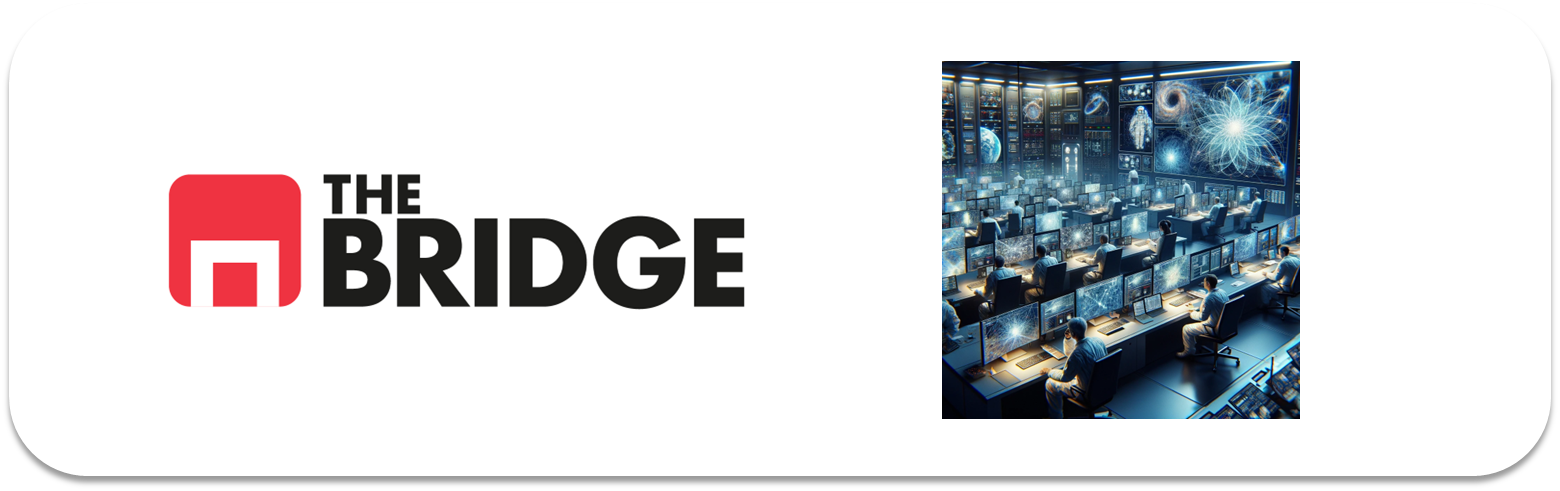

## PRACTICA OBLIGATORIA: **Transfer Learning y Fine Tuning**

* La práctica obligatoria de esta unidad consiste en un repetir el ejercicio de construcción de un modelo de clasificación de paisajes pero usando un modelo preentrenado. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import os
import cv2
import tensorflow as tf
import keras



from skimage.io import imread
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from tensorflow.keras.preprocessing import image
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications.resnet_v2 import ResNet50V2, decode_predictions

### Objetivo del ejercicio

Comparar una red convolucional hecha ad-hoc frente a los modelos preentrenados y ajustados con fine tuning y transfer learning. Para ello emplea el dataset de paisajes del conjunto de ejercicios de la unidad anterior.


### Se pide

1. Preparar los datos del modelo y las funciones de visualización, copia para ello todo lo que necesites de las soluciones del ejercicio de clasificación de paisajes de la unidad anterior.

2. Escoger entre uno de los modelos VGG-19, InceptionV3 y MobileNetV2 (todos en https://keras.io/api/applications/) (Se aconseja este último si no tenemos un ordenador muy potente). Si no te haces con estos puedes recurrir a la ResNetV50.

4. Hacer un transfer-learning con una cabeza de como mucho 2 capas densas ocultas y una de salida. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

5. Hacer un fine-tuning con la misma cabeza diseñada en el punto anterior. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

6. Comparar los resultados con los obtenidos con la red convolucional del ejercicio mencionado.

EXTRA:
- Repetir el transfer learning empleando aumentado de imágenes.



1. Preparar los datos del modelo y las funciones de visualización, copia para ello todo lo que necesites de las soluciones del ejercicio de clasificación de paisajes de la unidad anterior.

In [13]:

TRAIN_PATH = "./data/seg_train/"
TEST_PATH = "./data/seg_test/"

IMG_WIDTH = IMG_HEIGHT = 75

In [14]:
def read_data(directorio, reshape_dim = (IMG_WIDTH,IMG_HEIGHT)):
    X = [] 
    y = []
    supported_extensions = (".jpg", ".jpeg", ".png")  # Extensiones soportadas
    
    for folder in os.listdir(directorio):
        folder_path = os.path.join(directorio, folder)
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                if file.endswith(supported_extensions):
                    file_path = os.path.join(folder_path, file)
                    image = imread(file_path)
                    if image is not None:
                        image = cv2.resize(image, reshape_dim)  # Redimensionamos las imágenes
                        if image.shape == (*reshape_dim, 3):  # Asegurarse de que la imagen tiene 3 canales
                            X.append(image / 255.0)
                            y.append(folder)

    return np.array(X), np.array(y)

def show_images_batch(paisajes, names=[], n_cols=5, size_scale=2):
    n_rows = ((len(paisajes) - 1) // n_cols + 1)
    plt.figure(figsize=(n_cols * size_scale, n_rows * 1.1 * size_scale))
    for index, paisaje in enumerate(paisajes):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(paisaje, cmap="Greys")
        plt.axis("off")
        if len(names):
            plt.title(names[index])

In [15]:
X_train,y_train = read_data(TRAIN_PATH, (IMG_WIDTH, IMG_HEIGHT))
X_test, y_test = read_data(TEST_PATH, (IMG_WIDTH, IMG_HEIGHT))

In [16]:
# Verificar formas de datos
print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}, y_test shape: {y_test.shape}')

X_train shape: (14034, 75, 75, 3), y_train shape: (14034,)
X_test shape: (3000, 75, 75, 3), y_test shape: (3000,)


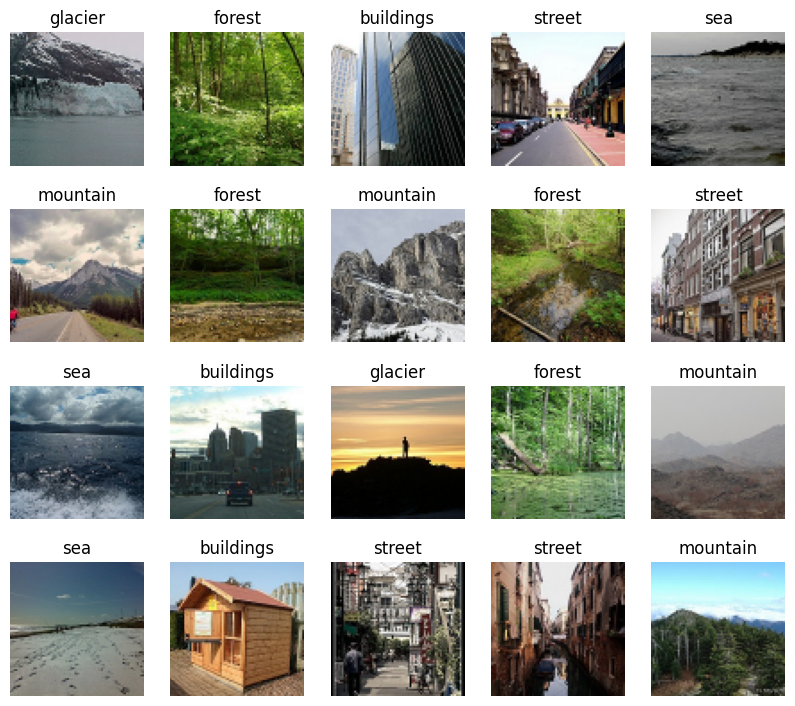

In [20]:
#pintado de imagenes
indices = np.random.randint(0,len(X_train),20)
show_images_batch(X_train[indices], names = y_train[indices], n_cols = 5)

2. Escoger entre uno de los modelos VGG-19, InceptionV3 y MobileNetV2 (todos en https://keras.io/api/applications/) (Se aconseja este último si no tenemos un ordenador muy potente). Si no te haces con estos puedes recurrir a la ResNetV50.

In [19]:
'''Cargamos toda la red ya entrenada, y la usaremos para predecir
include_top=True --> Para que incluya la fully connected layer.
include_top=False --> Desarrollamos la fully connected layer
ojo el input shape que sea el de las imagenes que introduciremos. Esta limitado a imagenes de tamaño 224x224
classifier_activation se usa si include_top=True
'''

base_model = ResNet50V2(input_shape=(224, 224,3),
                        include_top=True, # Como vamos a emplearla directamente, incluimos también la parte de capas densas que hacen la predicción en este caso clasificación de imagenes 
                        weights="imagenet", # Se carga con los pesos entrenados para el dataset de imagenet
                        classifier_activation="softmax")

102869336/102869336 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


4. Hacer un transfer-learning con una cabeza de como mucho 2 capas densas ocultas y una de salida. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

5. Hacer un fine-tuning con la misma cabeza diseñada en el punto anterior. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

In [ ]:
base_model.trainable = True

# Recompilar el modelo con una tasa de aprendizaje más baja
model.compile(optimizer=Adam(1e-5), loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])

history_fine = model.fit(train_generator, validation_data=validation_generator, steps_per_epoch=100, epochs=10)

In [ ]:
loss, accuracy = model.evaluate(validation_generator)
print(f'Loss: {loss}, Accuracy: {accuracy}')

# Mostrar matriz de confusión y reporte de clasificación
from sklearn.metrics import classification_report, confusion_matrix
y_pred = model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
print(confusion_matrix(y_test, y_pred_classes))
print(classification_report(y_test, y_pred_classes))

6. Comparar los resultados con los obtenidos con la red convolucional del ejercicio mencionado.